# Comparing Automated and Manual IFCB Counts

### Importing in manual counts from matlab

In [3]:
library("dplyr")
library("tidyr")
library("ggplot2") #for plotting
library("lubridate") #working with dates
library("ggrepel") #for getting date labels to repel plot line
library("data.table")
library("zoo")
library("scales")
library("codyn")

basepath = "/D/MIT-WHOI/github_repos/plankton-index/"

df.class2use <- read.csv(paste0(basepath,"/data/class2use.csv")) #manual ifcb headers
dfm <- read.csv(paste0(basepath,"/data/classcount.csv"),header = FALSE)
filelist <- read.csv(paste0(basepath,"/data/filelist.csv"),header = TRUE) #list of IFCB filenames

names(dfm) <- as.matrix(df.class2use[1,]) #setting column names from class2use
dfm$filelist <- filelist[,1] #setting datacolumn for filenames

df.date <- read.csv(paste0(basepath,"/data/manual_mat_date.csv"),header = FALSE)

dfm$datetime <- as.Date(ISOdatetime(df.date[,1],df.date[,2],df.date[,3],df.date[,4],df.date[,5],df.date[,6],tz = "UTC"))

head(dfm)

dfm$richness <- NA #calculating richness
for(aa in 1:nrow(dfm)){
    dfm$richness[aa] = length(which(dfm[aa,which(colnames(dfm)=="Asterionellopsis_glacialis"):which(colnames(dfm) == "Thalassiosira_spaffmala")] != 0))
}

head(dfm)


Asterionellopsis_glacialis Ceratium Chaetoceros Corethron_hystrix
1 2                          0        61          1                
2 1                          1        48          1                
3 2                          0        54          0                
4 3                          0        20          1                
5 3                          0        19          1                
6 4                          0        17          0                
  Cylindrotheca Dactyliosolen_fragilissimus Dactyliosolen_blavyanus Dictyocha
1  2            9                           5                       0        
2  4            5                           2                       0        
3  5            8                           1                       0        
4 10            0                           5                       1        
5  4            0                           7                       1        
6  5            0                           1                       0        
  Dinobryon Ditylum_brightwellii ⋯ Prorocentrum_triestinum Scrippsiella
1  0        1                    ⋯ 0                       0           
2  0        2                    ⋯ 0                       0           
3  0        1                    ⋯ 0                       0           
4 10        0                    ⋯ 0                       0           
5 13        0                    ⋯ 0                       0           
6  0        0                    ⋯ 0                       0           
  Strobilidium_morphotype1 fiber unknown3_squiggle Amylax Thalassiosira_rotula
1 0                        0     0                 0      0                   
2 0                        0     0                 0      0                   
3 0                        0     0                 0      0                   
4 0                        0     0                 0      0                   
5 0                        0     0                 0      0                   
6 0                        0     0                 0      0                   
  Thalassiosira_spaffmala filelist                 datetime  
1 0                       D20181008T214137_IFCB109 2018-10-08
2 0                       D20181008T220407_IFCB109 2018-10-08
3 0                       D20181008T222637_IFCB109 2018-10-08
4 0                       D20181031T201422_IFCB010 2018-10-31
5 0                       D20181031T203656_IFCB010 2018-10-31
6 8                       D20181120T194146_IFCB010 2018-11-20

Asterionellopsis_glacialis Ceratium Chaetoceros Corethron_hystrix
1 2                          0        61          1                
2 1                          1        48          1                
3 2                          0        54          0                
4 3                          0        20          1                
5 3                          0        19          1                
6 4                          0        17          0                
  Cylindrotheca Dactyliosolen_fragilissimus Dactyliosolen_blavyanus Dictyocha
1  2            9                           5                       0        
2  4            5                           2                       0        
3  5            8                           1                       0        
4 10            0                           5                       1        
5  4            0                           7                       1        
6  5            0                           1                       0        
  Dinobryon Ditylum_brightwellii ⋯ Scrippsiella Strobilidium_morphotype1 fiber
1  0        1                    ⋯ 0            0                        0    
2  0        2                    ⋯ 0            0                        0    
3  0        1                    ⋯ 0            0                        0    
4 10        0                    ⋯ 0            0                        0    
5 13        0                    ⋯ 0            0                        0    
6  0        0                    ⋯ 0            0                        0    
  unknown3_squiggle Amylax Thalassiosira_rotula Thalassiosira_spaffmala
1 0                 0      0                    0                      
2 0                 0      0                    0                      
3 0                 0      0                    0                      
4 0                 0      0                    0                      
5 0                 0      0                    0                      
6 0                 0      0                    8                      
  filelist                 datetime   richness
1 D20181008T214137_IFCB109 2018-10-08 48      
2 D20181008T220407_IFCB109 2018-10-08 45      
3 D20181008T222637_IFCB109 2018-10-08 35      
4 D20181031T201422_IFCB010 2018-10-31 41      
5 D20181031T203656_IFCB010 2018-10-31 40      
6 D20181120T194146_IFCB010 2018-11-20 38

### Importing automated IFCB class counts

In [10]:
basepath = "/D/MIT-WHOI/github_repos/plankton-index/"
dfc = read.csv(paste0(basepath,'data/count_by_class_time_seriesCNN_hourly08Sep2021.csv')) #hourly count of plankton
cl =  read.csv(paste0(basepath,'/data/IFCB_classlist_type.csv'))

mapf <- function(Fgroup){
    which(colnames(dfc) %in% cl[cl[Fgroup] == 1,]$CNN_classlist)} #generates list of species within the specified functional grou

#removing categories within the Other.not.alive and the IFCB.artifact groups from dfc
dfc <- dfc %>% select(-c(mapf("Other.not.alive"),mapf("IFCB.artifact"),mix)) %>% na.omit(dfc)

#extracting dates and creating columns for individual date values
dfc$datetime = as.Date(dfc$datetime, format = "%d-%b-%Y %H:%M:%S")
dfc$totalcount = rowSums(subset(dfc, select=Acanthoica_quattrospina:zooplankton))
dfc$year = year(dfc$date)
dfc$month = sprintf("%02d",month(dfc$date))
dfc$day =  sprintf("%02d",day(dfc$date))
dfc$my = paste0(dfc$year,"_",dfc$month)
dfc$week = week(dfc$date)
dfc$wy = paste0(dfc$year,"_",dfc$week)

head(dfc)
#grouping at the week of the year
dfc.wy <- dfc%>% group_by(wy)%>% mutate_at(vars(Acanthoica_quattrospina:totalcount),sum) %>% distinct(wy,.keep_all = TRUE)

# head(dfc.wy)
df_to_rac = dfc.wy[order(dfc.wy$datetime),]

#making copies of df_to_rac
df.rank = data.frame(df_to_rac)
df.rel.abund = data.frame(df_to_rac)

dfc$richness <- NA
for(aa in 1:nrow(dfc)){
    dfc$richness[aa] = length(which(dfc[aa,which(colnames(dfc)=="Acanthoica_quattrospina"):which(colnames(dfc) == "zooplankton")] != 0))
}

head(dfc)

datetime   milliliters_analyzed Acanthoica_quattrospina Akashiwo
1 2006-06-06  4.063245            0                       0       
2 2006-06-06  4.337958            0                       0       
3 2006-06-06 13.199159            0                       0       
4 2006-06-06  8.019507            0                       0       
5 2006-06-06 14.931327            1                       0       
6 2006-06-06  8.713200            0                       0       
  Alexandrium_catenella Amphidinium Amylax Apedinella
1 0                     0           0      0         
2 0                     0           0      0         
3 0                     0           0      0         
4 0                     0           0      0         
5 0                     0           0      3         
6 0                     0           0      3         
  Asterionellopsis_glacialis Bacillaria ⋯ square_unknown unknown2 zooplankton
1 1                          0          ⋯ 0              0        0          
2 0                          0          ⋯ 0              0        0          
3 1                          0          ⋯ 0              0        0          
4 1                          0          ⋯ 0              0        0          
5 0                          0          ⋯ 0              0        1          
6 0                          0          ⋯ 0              0        0          
  totalcount year month day my      week wy     
1  407       2006 06    06  2006_06 23   2006_23
2  528       2006 06    06  2006_06 23   2006_23
3 1335       2006 06    06  2006_06 23   2006_23
4  820       2006 06    06  2006_06 23   2006_23
5 1588       2006 06    06  2006_06 23   2006_23
6 1050       2006 06    06  2006_06 23   2006_23

datetime   milliliters_analyzed Acanthoica_quattrospina Akashiwo
1 2006-06-06  4.063245            0                       0       
2 2006-06-06  4.337958            0                       0       
3 2006-06-06 13.199159            0                       0       
4 2006-06-06  8.019507            0                       0       
5 2006-06-06 14.931327            1                       0       
6 2006-06-06  8.713200            0                       0       
  Alexandrium_catenella Amphidinium Amylax Apedinella
1 0                     0           0      0         
2 0                     0           0      0         
3 0                     0           0      0         
4 0                     0           0      0         
5 0                     0           0      3         
6 0                     0           0      3         
  Asterionellopsis_glacialis Bacillaria ⋯ unknown2 zooplankton totalcount year
1 1                          0          ⋯ 0        0            407       2006
2 0                          0          ⋯ 0        0            528       2006
3 1                          0          ⋯ 0        0           1335       2006
4 1                          0          ⋯ 0        0            820       2006
5 0                          0          ⋯ 0        1           1588       2006
6 0                          0          ⋯ 0        0           1050       2006
  month day my      week wy      richness
1 06    06  2006_06 23   2006_23 28      
2 06    06  2006_06 23   2006_23 30      
3 06    06  2006_06 23   2006_23 32      
4 06    06  2006_06 23   2006_23 26      
5 06    06  2006_06 23   2006_23 62      
6 06    06  2006_06 23   2006_23 54

In [22]:
dfc$datetime[which(dfc$richness <= 1& dfc$year == 2015)]



Date of length 0

### plotting manual species abundance

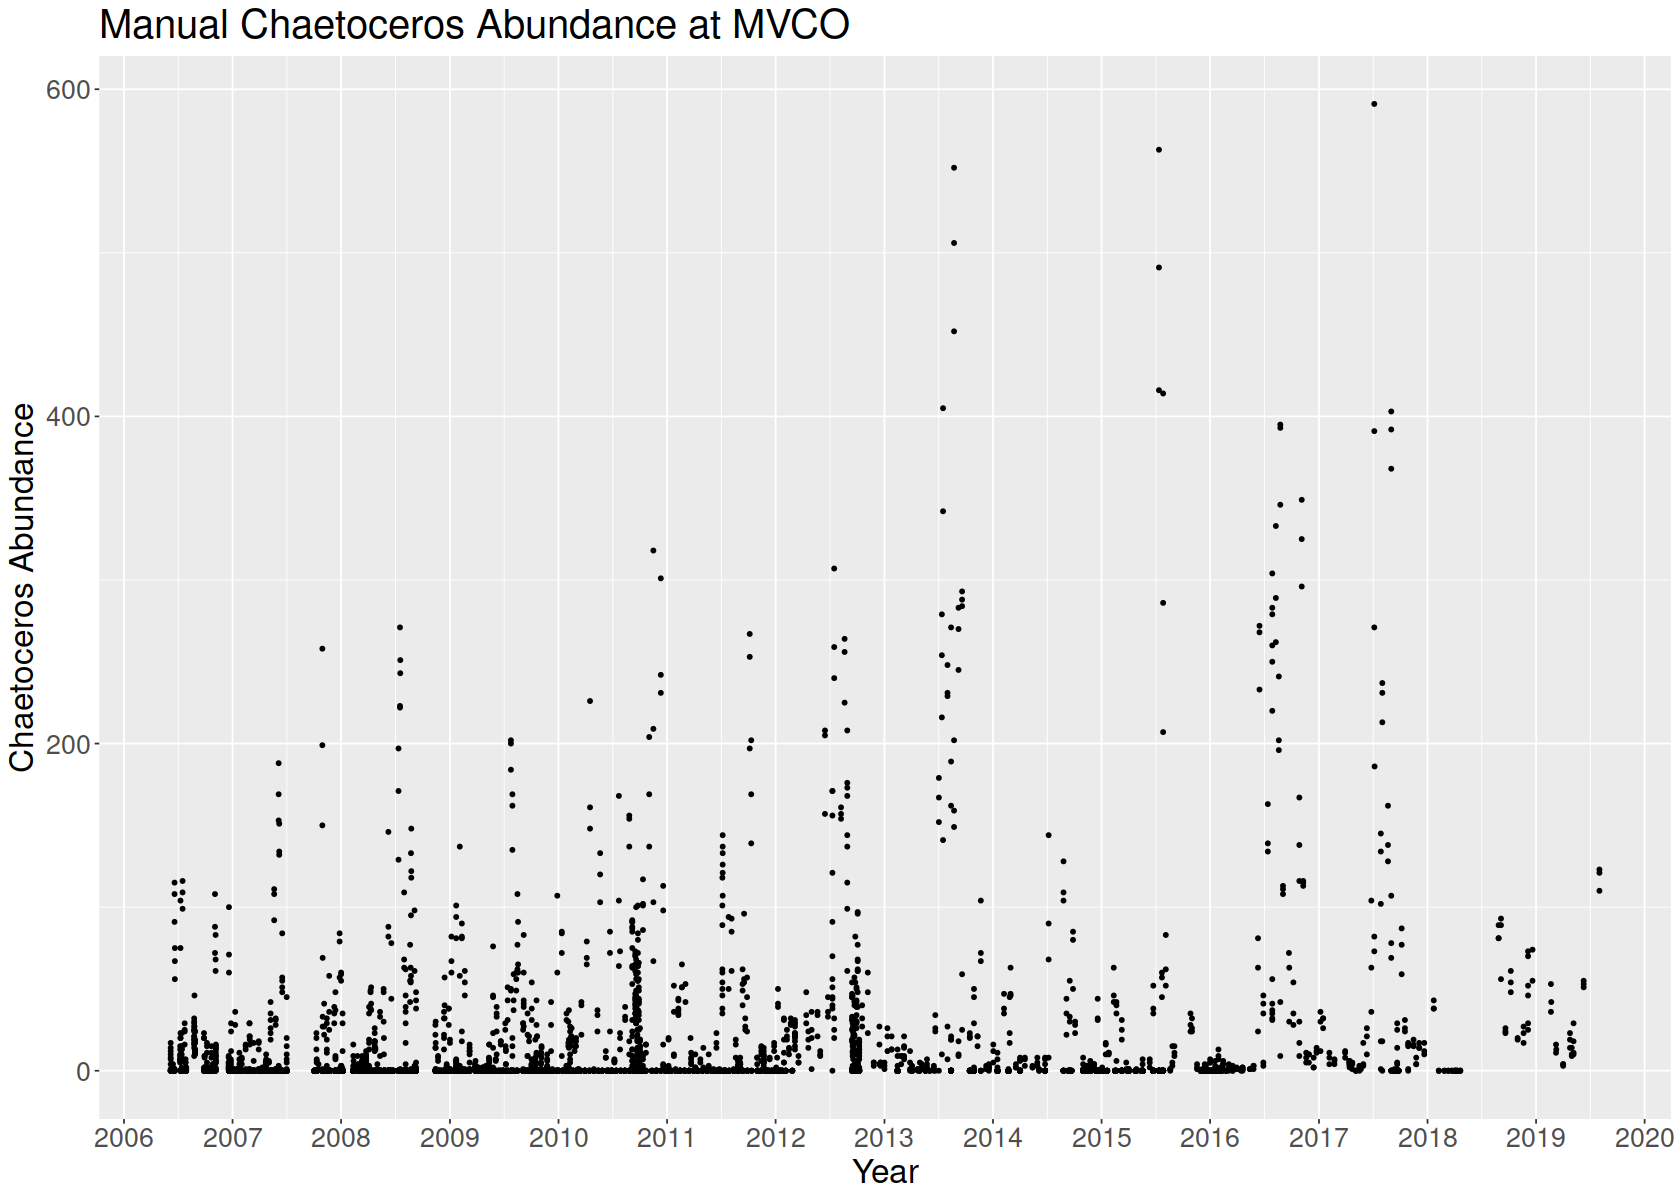

In [21]:

options(repr.plot.width=14, repr.plot.height=10) #set plot size

species = "Chaetoceros"
ggplot(data = dfm, aes_string(x = "datetime", y = species)) +
    geom_point(size = 1) +
    theme(text = element_text(size = 20))+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))+
    ggtitle(paste0("Manual ",species," Abundance at MVCO"))+
    ylab(paste0(species," Abundance"))+
    xlab("Year")

### Direct Comparison of Species Richness

In [14]:
head(dfm)
head(dfc)

mL <- read.csv(paste0(basepath,"/data/ml_analyzed_mat.csv"))
head(mL)

Asterionellopsis_glacialis Ceratium Chaetoceros Corethron_hystrix
1 2                          0        61          1                
2 1                          1        48          1                
3 2                          0        54          0                
4 3                          0        20          1                
5 3                          0        19          1                
6 4                          0        17          0                
  Cylindrotheca Dactyliosolen_fragilissimus Dactyliosolen_blavyanus Dictyocha
1  2            9                           5                       0        
2  4            5                           2                       0        
3  5            8                           1                       0        
4 10            0                           5                       1        
5  4            0                           7                       1        
6  5            0                           1                       0        
  Dinobryon Ditylum_brightwellii ⋯ Scrippsiella Strobilidium_morphotype1 fiber
1  0        1                    ⋯ 0            0                        0    
2  0        2                    ⋯ 0            0                        0    
3  0        1                    ⋯ 0            0                        0    
4 10        0                    ⋯ 0            0                        0    
5 13        0                    ⋯ 0            0                        0    
6  0        0                    ⋯ 0            0                        0    
  unknown3_squiggle Amylax Thalassiosira_rotula Thalassiosira_spaffmala
1 0                 0      0                    0                      
2 0                 0      0                    0                      
3 0                 0      0                    0                      
4 0                 0      0                    0                      
5 0                 0      0                    0                      
6 0                 0      0                    8                      
  filelist                 datetime   richness
1 D20181008T214137_IFCB109 2018-10-08 48      
2 D20181008T220407_IFCB109 2018-10-08 45      
3 D20181008T222637_IFCB109 2018-10-08 35      
4 D20181031T201422_IFCB010 2018-10-31 41      
5 D20181031T203656_IFCB010 2018-10-31 40      
6 D20181120T194146_IFCB010 2018-11-20 38

datetime   milliliters_analyzed Acanthoica_quattrospina Akashiwo
1 2006-06-06  4.063245            0                       0       
2 2006-06-06  4.337958            0                       0       
3 2006-06-06 13.199159            0                       0       
4 2006-06-06  8.019507            0                       0       
5 2006-06-06 14.931327            1                       0       
6 2006-06-06  8.713200            0                       0       
  Alexandrium_catenella Amphidinium Amylax Apedinella
1 0                     0           0      0         
2 0                     0           0      0         
3 0                     0           0      0         
4 0                     0           0      0         
5 0                     0           0      3         
6 0                     0           0      3         
  Asterionellopsis_glacialis Bacillaria ⋯ unknown2 zooplankton totalcount year
1 1                          0          ⋯ 0        0            407       2006
2 0                          0          ⋯ 0        0            528       2006
3 1                          0          ⋯ 0        0           1335       2006
4 1                          0          ⋯ 0        0            820       2006
5 0                          0          ⋯ 0        1           1588       2006
6 0                          0          ⋯ 0        0           1050       2006
  month day my      week wy      richness
1 06    06  2006_06 23   2006_23 28      
2 06    06  2006_06 23   2006_23 30      
3 06    06  2006_06 23   2006_23 32      
4 06    06  2006_06 23   2006_23 26      
5 06    06  2006_06 23   2006_23 62      
6 06    06  2006_06 23   2006_23 54

X3.9476 X3.9476.1 X3.9476.2 X3.9476.3 X3.9476.4 X3.9476.5 X3.9476.6 X3.9476.7
1 4.0586  4.0586    4.0586    4.0586    4.0586    4.0586    4.0586    4.0586   
2 4.1034  4.1034    4.1034    4.1034    4.1034    4.1034    4.1034    4.1034   
3 3.3929  3.3929    3.3929    3.3929    3.3929    3.3929    3.3929    3.3929   
4 3.4833  3.4833    3.4833    3.4833    3.4833    3.4833    3.4833    3.4833   
5 1.3492  1.3492    1.3492    1.3492    1.3492    1.3492    1.3492    1.3492   
6 3.3844  3.3844    3.3844    3.3844    3.3844    3.3844    3.3844    3.3844   
  X3.9476.8 X3.9476.9 ⋯ X3.9476.136 X3.9476.137 X3.9476.138 X3.9476.139
1 4.0586    4.0586    ⋯ 4.0586      4.0586      4.0586      4.0586     
2 4.1034    4.1034    ⋯ 4.1034      4.1034      4.1034      4.1034     
3 3.3929    3.3929    ⋯ 3.3929      3.3929      3.3929      3.3929     
4 3.4833    3.4833    ⋯ 3.4833      3.4833      3.4833      3.4833     
5 1.3492    1.3492    ⋯ 1.3492      1.3492      1.3492      1.3492     
6 3.3844    3.3844    ⋯ 3.3844      3.3844      3.3844      3.3844     
  X3.9476.140 X3.9476.141 X3.9476.142 X3.9476.143 X3.9476.144 X3.9476.145
1 4.0586      4.0586      4.0586      4.0586      4.0586      4.0586     
2 4.1034      4.1034      4.1034      4.1034      4.1034      4.1034     
3 3.3929      3.3929      3.3929      3.3929      3.3929      3.3929     
4 3.4833      3.4833      3.4833      3.4833      3.4833      3.4833     
5 1.3492      1.3492      1.3492      1.3492      1.3492      1.3492     
6 3.3844      3.3844      3.3844      3.3844      3.3844      3.3844

Warning message:
“Removed 116 rows containing missing values (geom_point).”


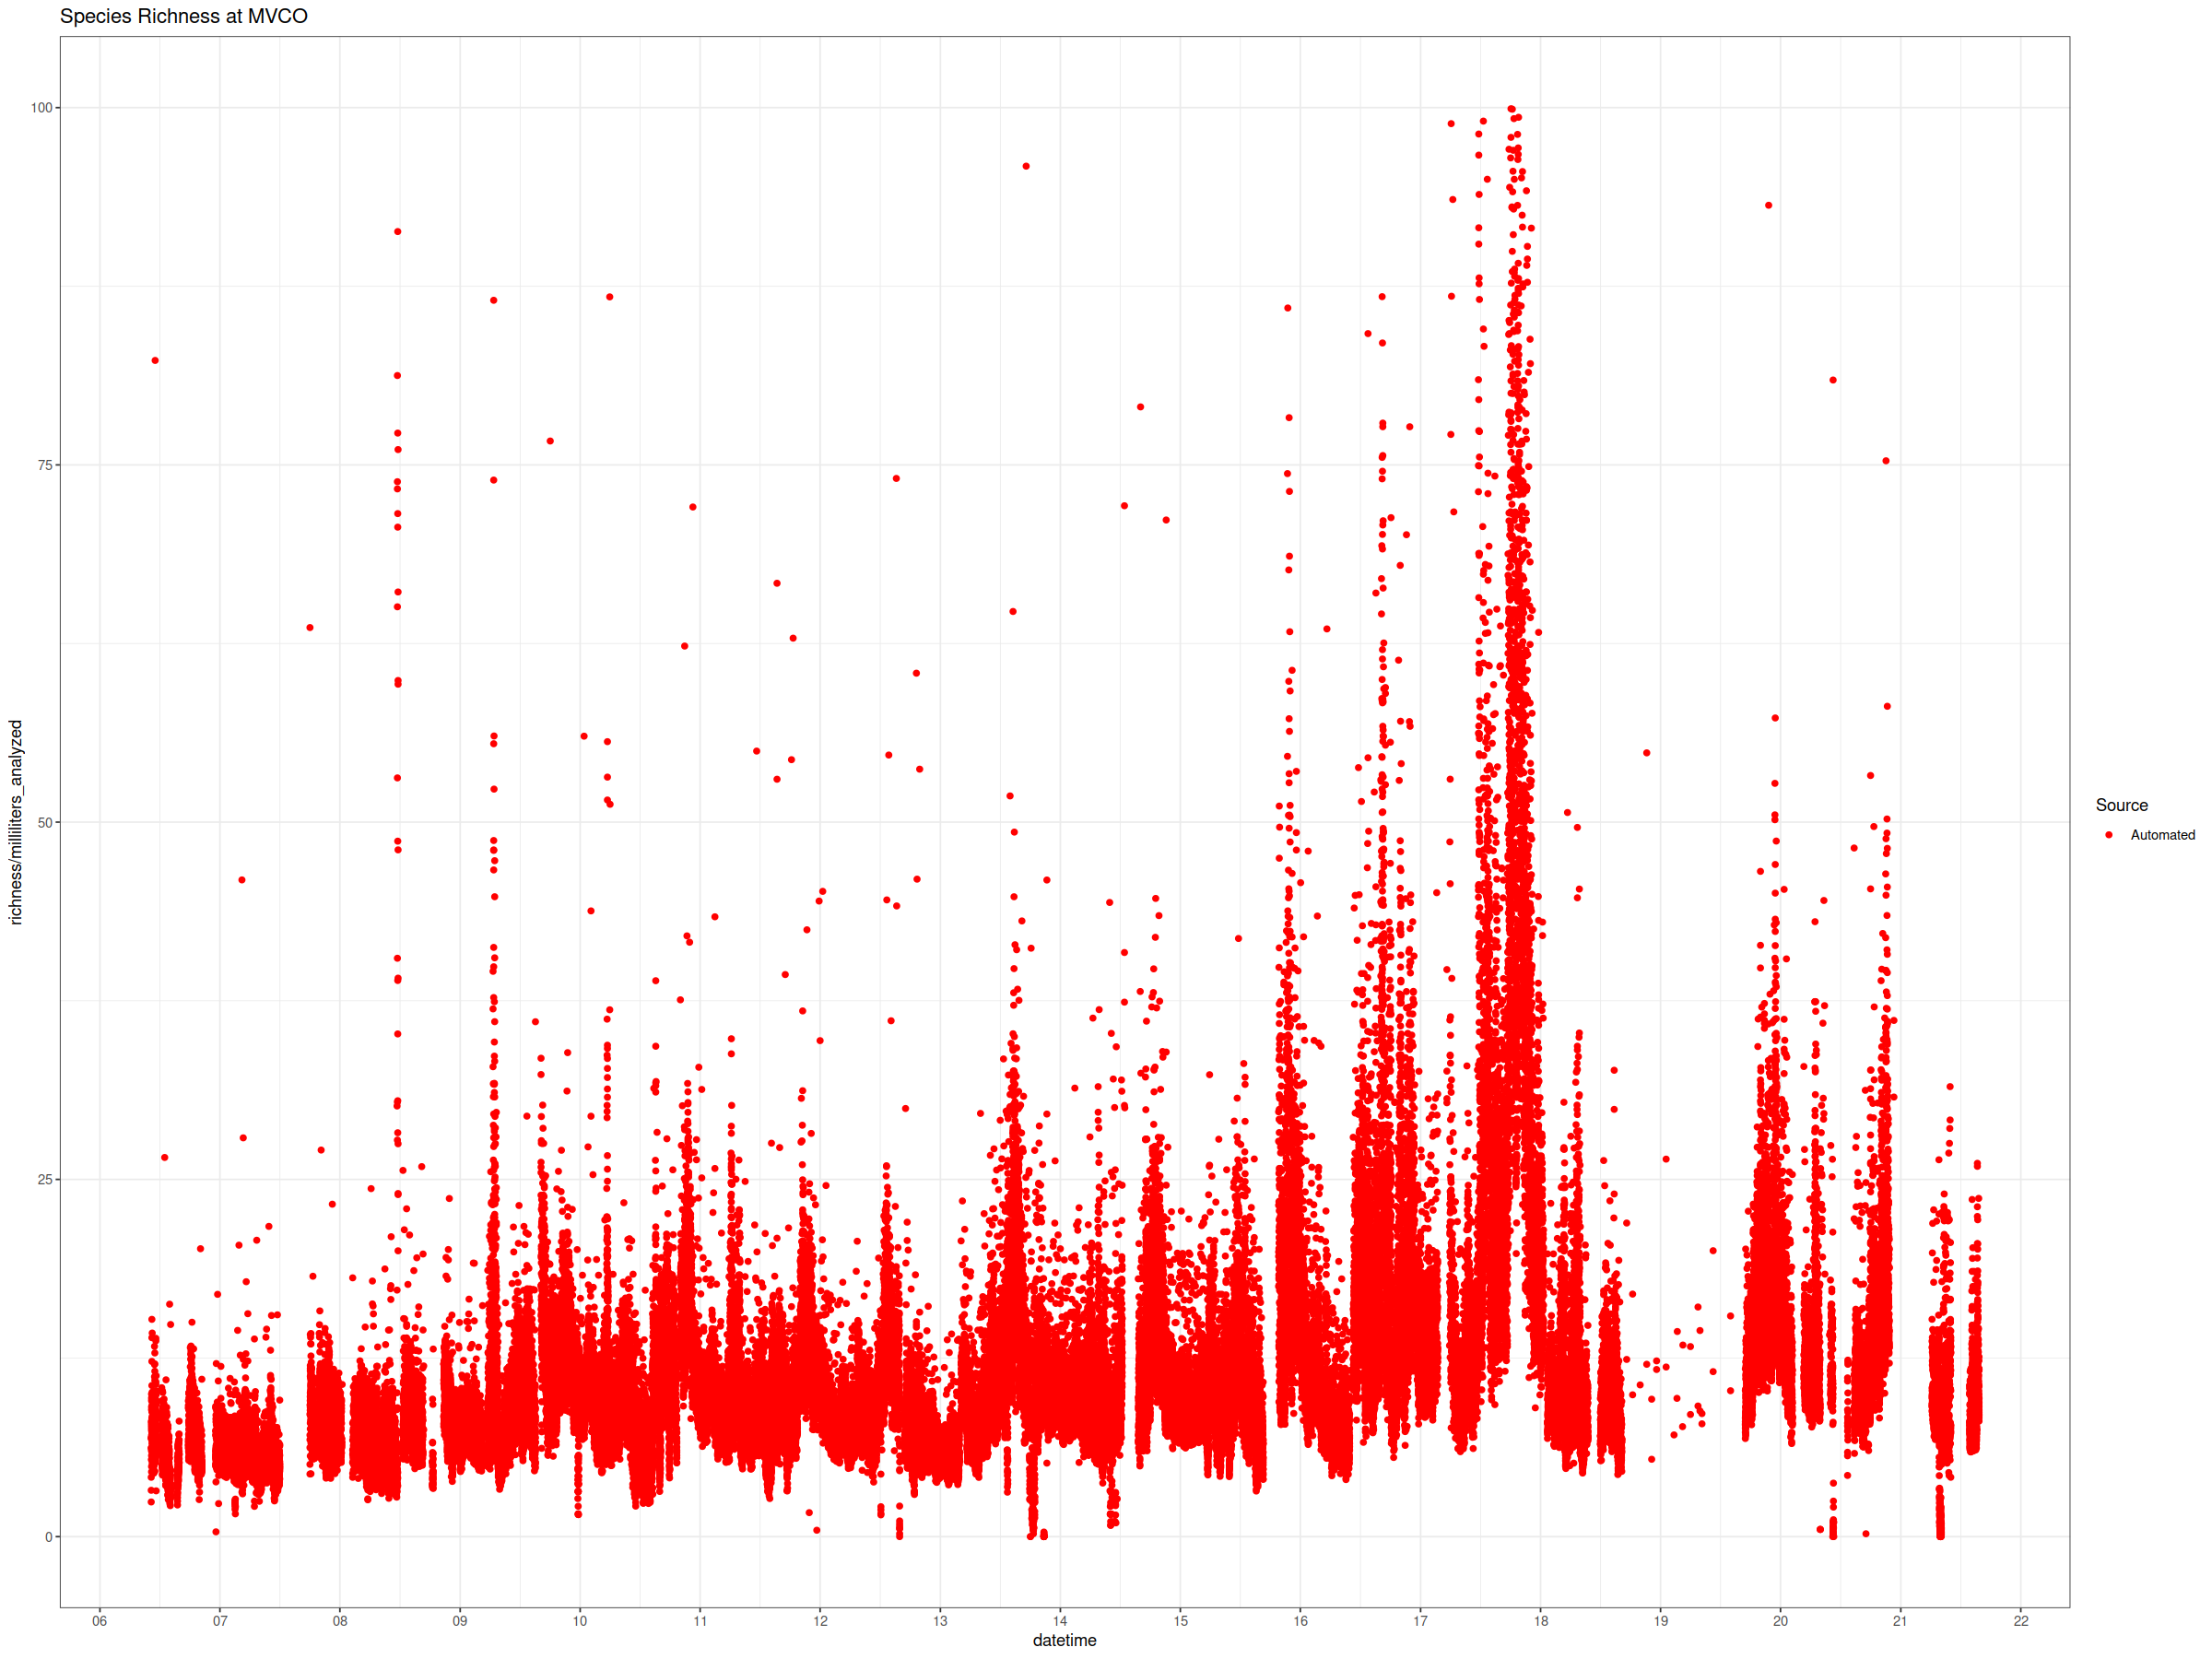

In [15]:
options(repr.plot.width=20, repr.plot.height=15)

ggplot() +
#     geom_point(data = dfm, aes(x = datetime, y = richness,color = "Manual"))+
    geom_point(data = dfc, aes(x = datetime,y = richness/milliliters_analyzed,color = "Automated"))+
    scale_x_date(breaks = "1 year", labels=date_format("%y"))+
    theme(text = element_text(size = 30))+
    ggtitle("Species Richness at MVCO")+
    scale_color_manual(name = "Source", values = c("Automated" = "red", "Manual" = "blue"))+
    ylim(c(0,100))+
    theme_bw()


# ggplot(data = dfm,aes(x = datetime, y = richness)) +geom_point()

Warning message:
“Removed 729 row(s) containing missing values (geom_path).”


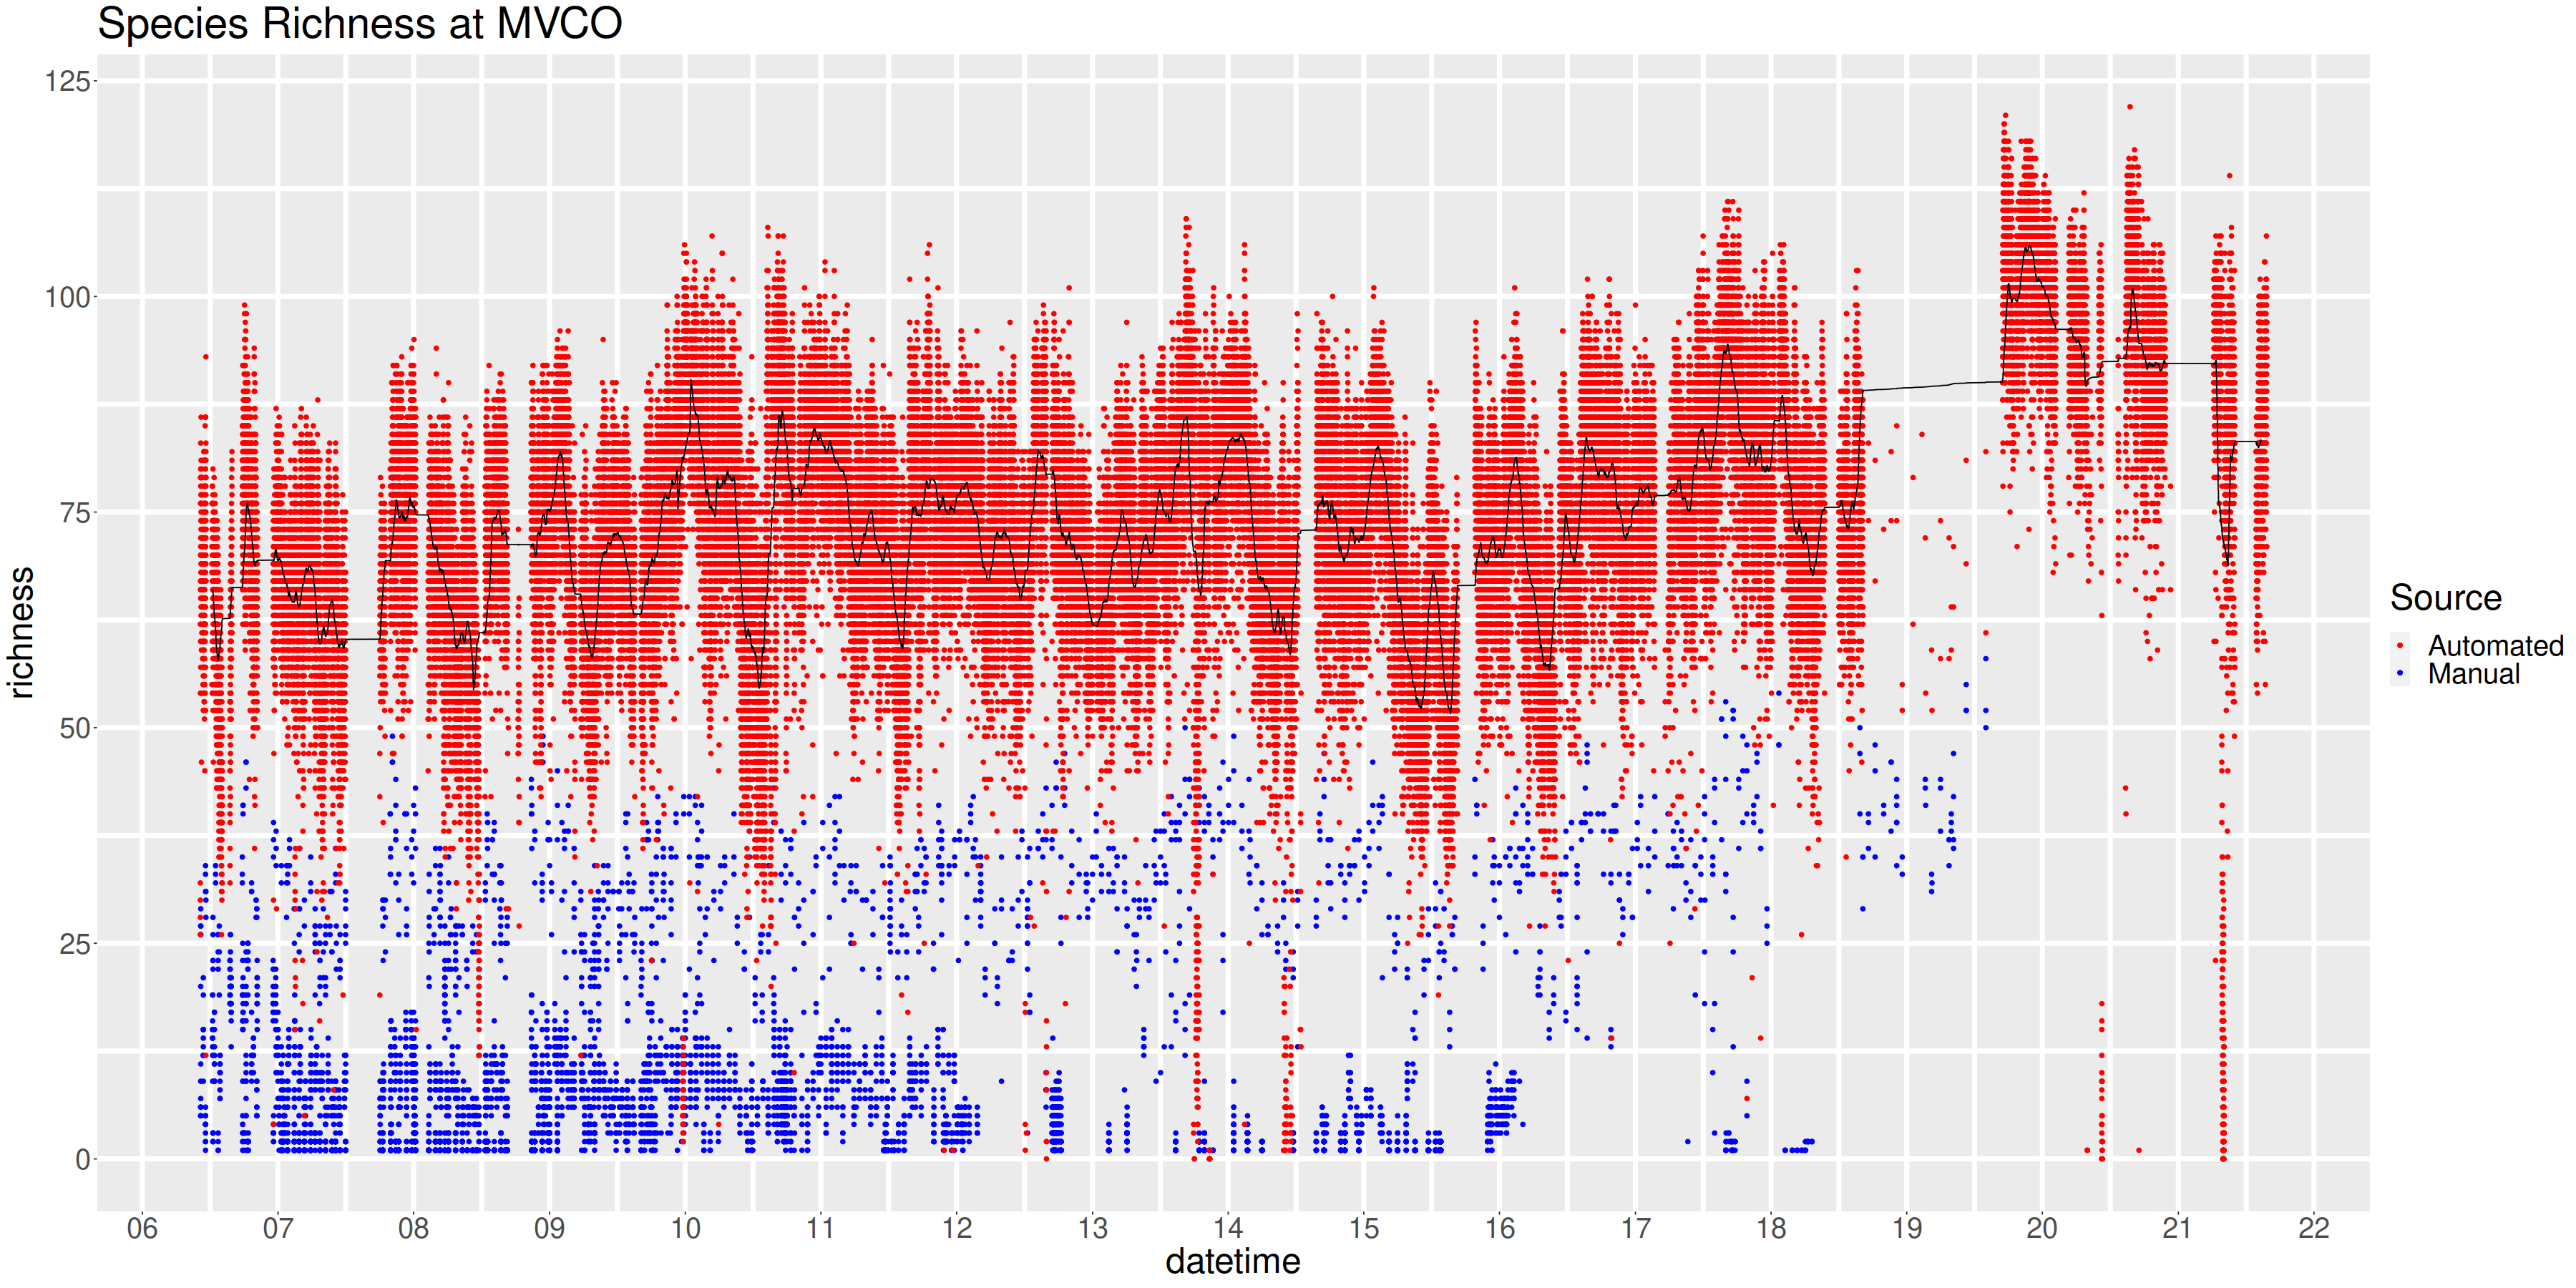

In [16]:
options(repr.plot.width=30, repr.plot.height=15)

ggplot() +
    geom_point(data = dfm, aes(x = datetime, y = richness,color = "Manual"))+
    geom_point(data = dfc, aes(x = datetime,y = richness,color = "Automated"))+
    scale_x_date(breaks = "1 year", labels=date_format("%y"))+
    theme(text = element_text(size = 30),panel.grid.minor = element_line(size = 2), panel.grid.major = element_line(size = 2))+
    ggtitle("Species Richness at MVCO")+
      geom_line(data = dfc,aes(x = datetime, y=rollmean(richness, 730, na.pad=TRUE))) +
    scale_color_manual(name = "Source", values = c("Automated" = "red", "Manual" = "blue"))


# ggplot(data = dfm,aes(x = datetime, y = richness)) +geom_point()


In [18]:
dfm$year = year(dfm$date)
dfm$month = sprintf("%02d",month(dfm$date))
dfm$day =  sprintf("%02d",day(dfm$date))
dfm$my = paste0(dfm$year,"_",dfm$month)
dfm$week = week(dfm$date)
dfm$wy = paste0(dfm$year,"_",dfm$week)

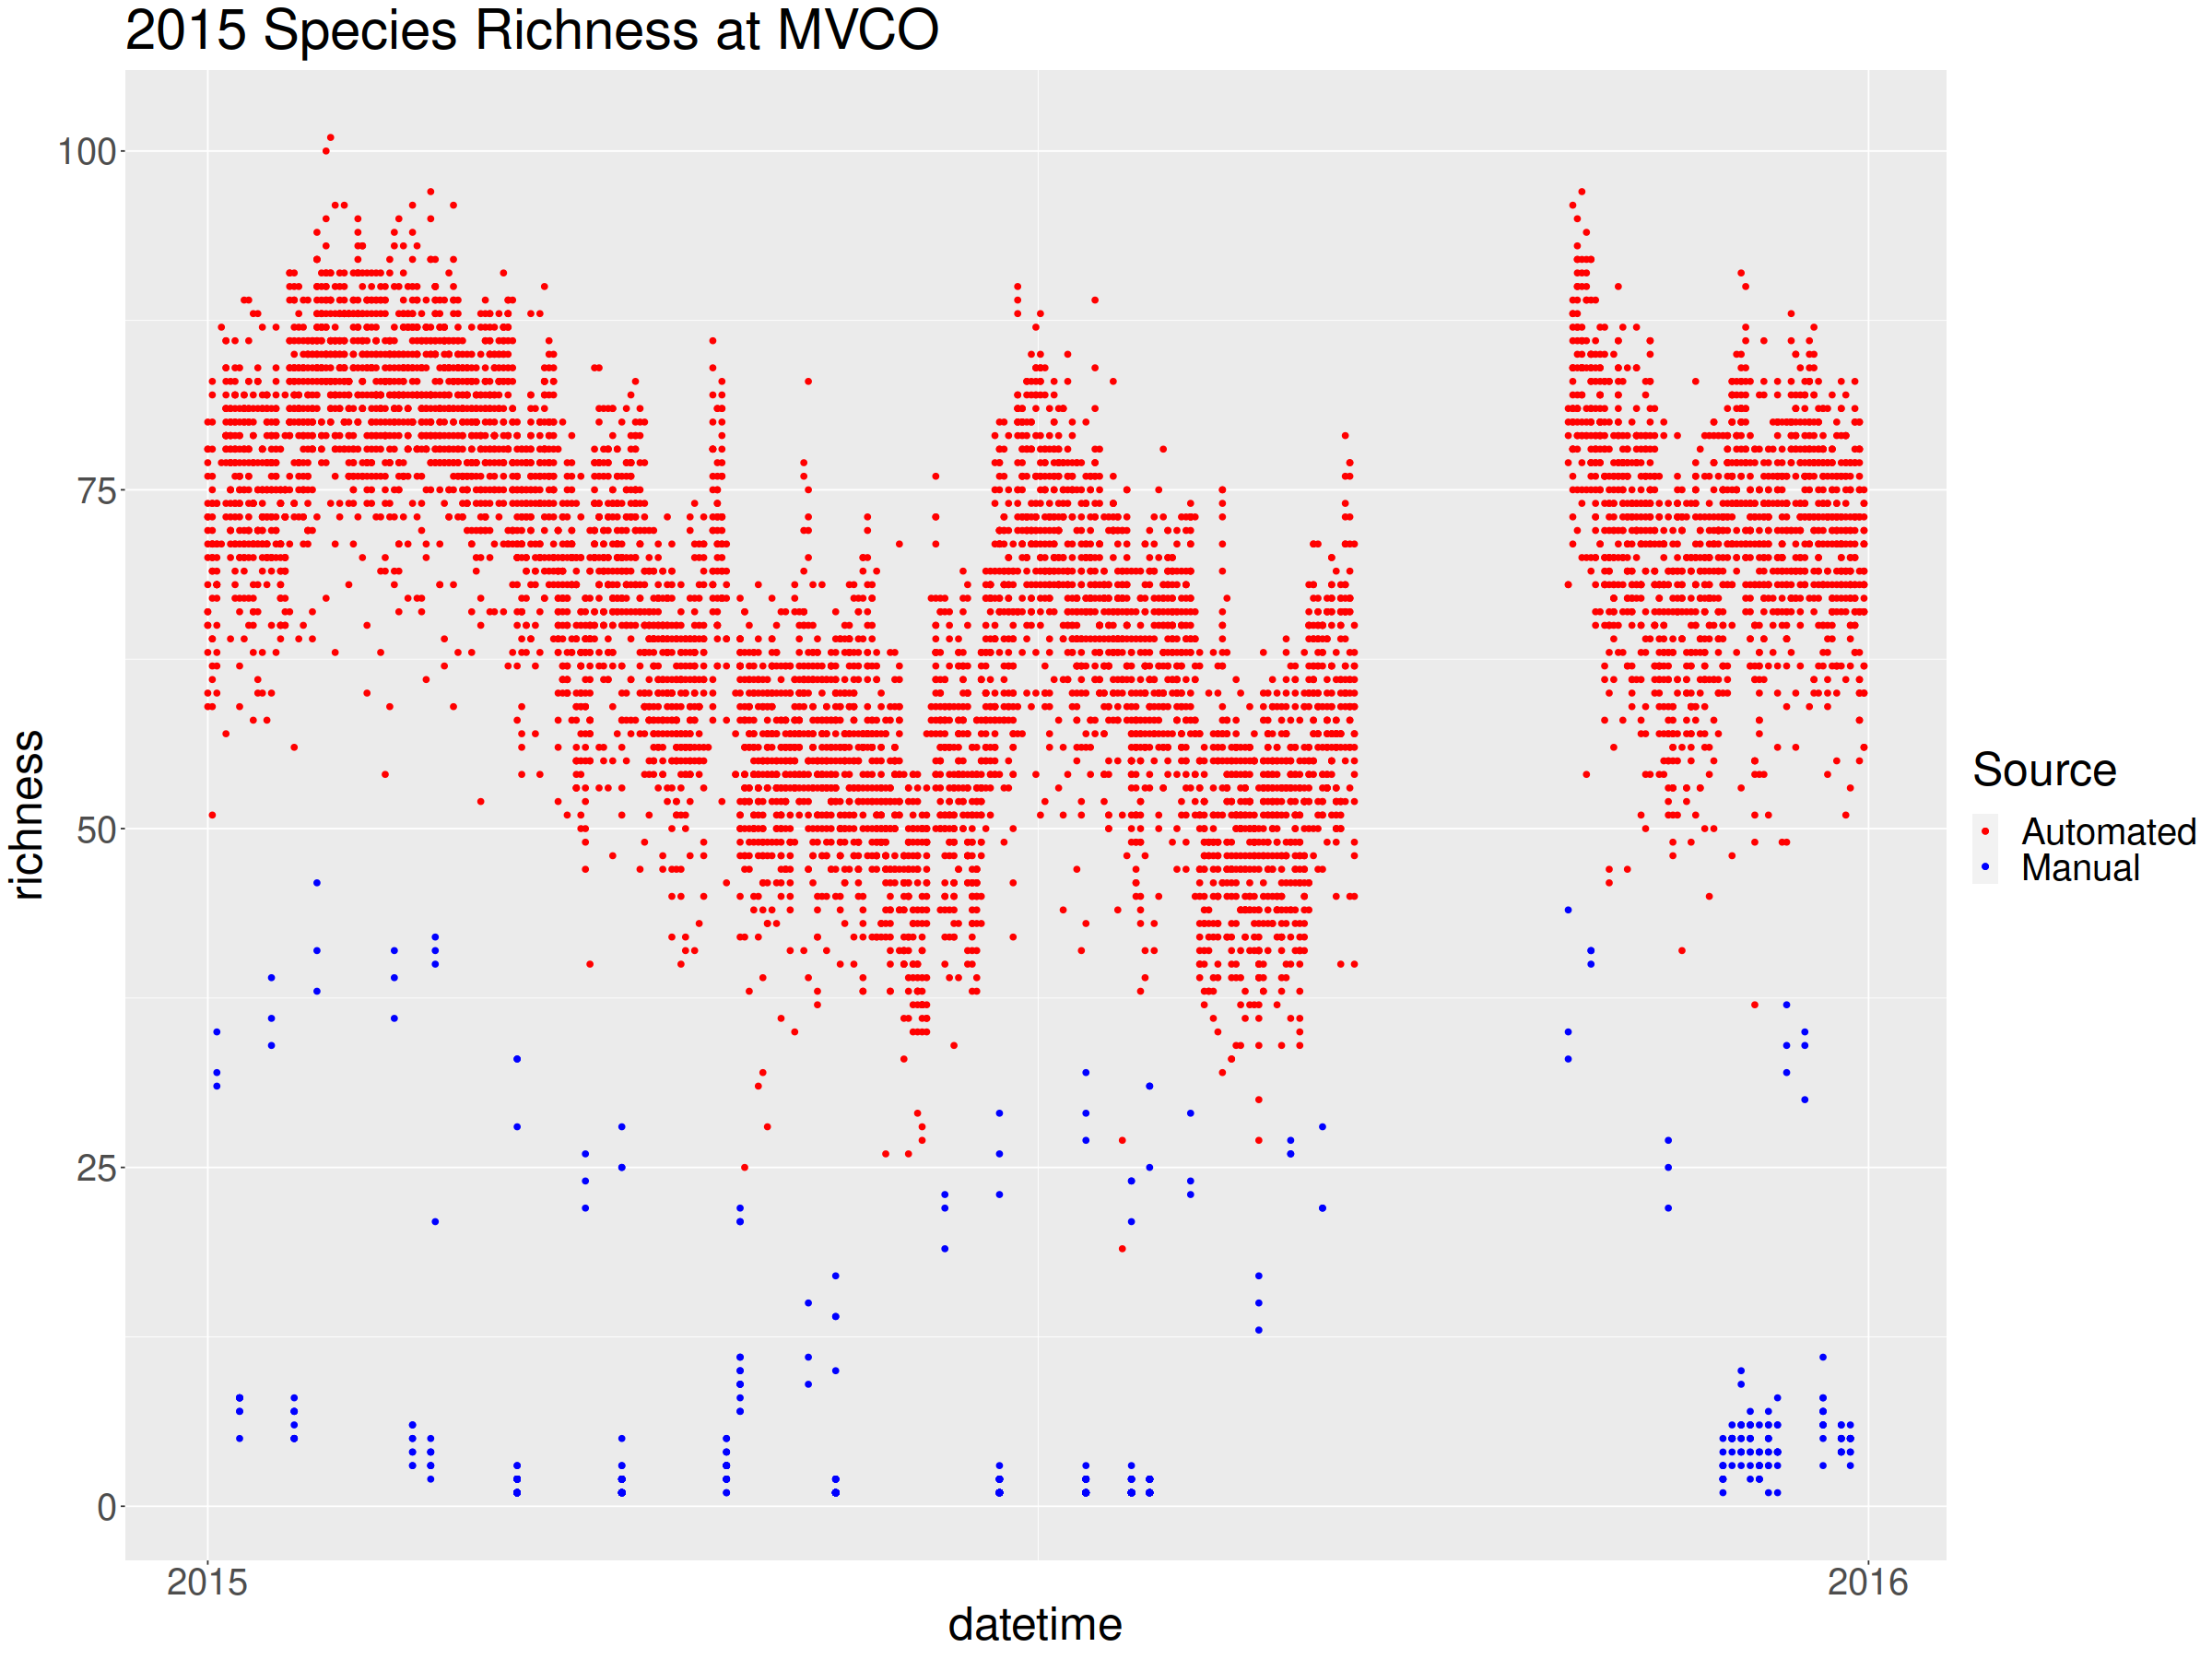

In [19]:
options(repr.plot.width=20, repr.plot.height=15)
plt.year = 2015
ggplot() +
    geom_point(data = dfm %>% filter(year == plt.year), aes(x = datetime, y = richness,color = "Manual"))+
    geom_point(data = dfc%>% filter(year == plt.year), aes(x = datetime,y = richness,color = "Automated"))+
    scale_x_date(breaks = "1 year", labels=date_format("%Y"))+
    theme(text = element_text(size = 30))+
    ggtitle(paste(plt.year,"Species Richness at MVCO"))+
    scale_color_manual(name = "Source", values = c("Automated" = "red", "Manual" = "blue"))



[1] "2015-03-12" "2015-03-12" "2015-03-12" "2015-03-15" "2015-03-23"
 [6] "2015-04-25" "2015-05-20" "2015-05-30" "2015-05-31" "2015-05-31"
[11] "2015-06-01" "2015-06-02" "2015-06-02" "2015-06-02" "2015-06-02"
[16] "2015-06-03" "2015-06-03" "2015-06-03" "2015-06-04" "2015-06-04"
[21] "2015-06-05" "2015-06-05" "2015-06-05" "2015-06-05" "2015-06-05"
[26] "2015-06-05" "2015-06-06" "2015-06-06" "2015-06-06" "2015-06-07"
[31] "2015-06-07" "2015-06-08" "2015-06-08" "2015-06-09" "2015-06-09"
[36] "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09"
[41] "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09"
[46] "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09"
[51] "2015-06-09" "2015-08-11" "2015-12-10" "2015-12-10"

datetime   milliliters_analyzed Acanthoica_quattrospina Akashiwo
1 2006-06-06  4.063245            0                       0       
2 2006-06-06  4.337958            0                       0       
3 2006-06-06 13.199159            0                       0       
4 2006-06-06  8.019507            0                       0       
5 2006-06-06 14.931327            1                       0       
6 2006-06-06  8.713200            0                       0       
  Alexandrium_catenella Amphidinium Amylax Apedinella
1 0                     0           0      0         
2 0                     0           0      0         
3 0                     0           0      0         
4 0                     0           0      0         
5 0                     0           0      3         
6 0                     0           0      3         
  Asterionellopsis_glacialis Bacillaria ⋯ unknown2 zooplankton totalcount year
1 1                          0          ⋯ 0        0            407       2006
2 0                          0          ⋯ 0        0            528       2006
3 1                          0          ⋯ 0        0           1335       2006
4 1                          0          ⋯ 0        0            820       2006
5 0                          0          ⋯ 0        1           1588       2006
6 0                          0          ⋯ 0        0           1050       2006
  month day my      week wy      richness
1 06    06  2006_06 23   2006_23 28      
2 06    06  2006_06 23   2006_23 30      
3 06    06  2006_06 23   2006_23 32      
4 06    06  2006_06 23   2006_23 26      
5 06    06  2006_06 23   2006_23 62      
6 06    06  2006_06 23   2006_23 54

In [6]:


dfc$datetime[which(dfc$richness <= 1& dfc$year == 2015)]

head(dfc)

[1] "2015-03-12" "2015-03-12" "2015-03-12" "2015-03-15" "2015-03-23"
 [6] "2015-04-25" "2015-05-20" "2015-05-30" "2015-05-31" "2015-05-31"
[11] "2015-06-01" "2015-06-02" "2015-06-02" "2015-06-02" "2015-06-02"
[16] "2015-06-03" "2015-06-03" "2015-06-03" "2015-06-04" "2015-06-04"
[21] "2015-06-05" "2015-06-05" "2015-06-05" "2015-06-05" "2015-06-05"
[26] "2015-06-05" "2015-06-06" "2015-06-06" "2015-06-06" "2015-06-07"
[31] "2015-06-07" "2015-06-08" "2015-06-08" "2015-06-09" "2015-06-09"
[36] "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09"
[41] "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09"
[46] "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09" "2015-06-09"
[51] "2015-06-09" "2015-08-11" "2015-12-10" "2015-12-10"

datetime   milliliters_analyzed Acanthoica_quattrospina Akashiwo
1 2006-06-06  4.063245            0                       0       
2 2006-06-06  4.337958            0                       0       
3 2006-06-06 13.199159            0                       0       
4 2006-06-06  8.019507            0                       0       
5 2006-06-06 14.931327            1                       0       
6 2006-06-06  8.713200            0                       0       
  Alexandrium_catenella Amphidinium Amylax Apedinella
1 0                     0           0      0         
2 0                     0           0      0         
3 0                     0           0      0         
4 0                     0           0      0         
5 0                     0           0      3         
6 0                     0           0      3         
  Asterionellopsis_glacialis Bacillaria ⋯ unknown2 zooplankton totalcount year
1 1                          0          ⋯ 0        0            407       2006
2 0                          0          ⋯ 0        0            528       2006
3 1                          0          ⋯ 0        0           1335       2006
4 1                          0          ⋯ 0        0            820       2006
5 0                          0          ⋯ 0        1           1588       2006
6 0                          0          ⋯ 0        0           1050       2006
  month day my      week wy      richness
1 06    06  2006_06 23   2006_23 28      
2 06    06  2006_06 23   2006_23 30      
3 06    06  2006_06 23   2006_23 32      
4 06    06  2006_06 23   2006_23 26      
5 06    06  2006_06 23   2006_23 62      
6 06    06  2006_06 23   2006_23 54

In [ ]:
dff = read.csv(paste0(basepath,"/data/manual_list.csv"),
                  header = FALSE)
colnames(dff) <- c("id","flag")
head(dff)


### Direct Comparisons at the Species Level

Warning message:
“Removed 54 rows containing missing values (geom_point).”


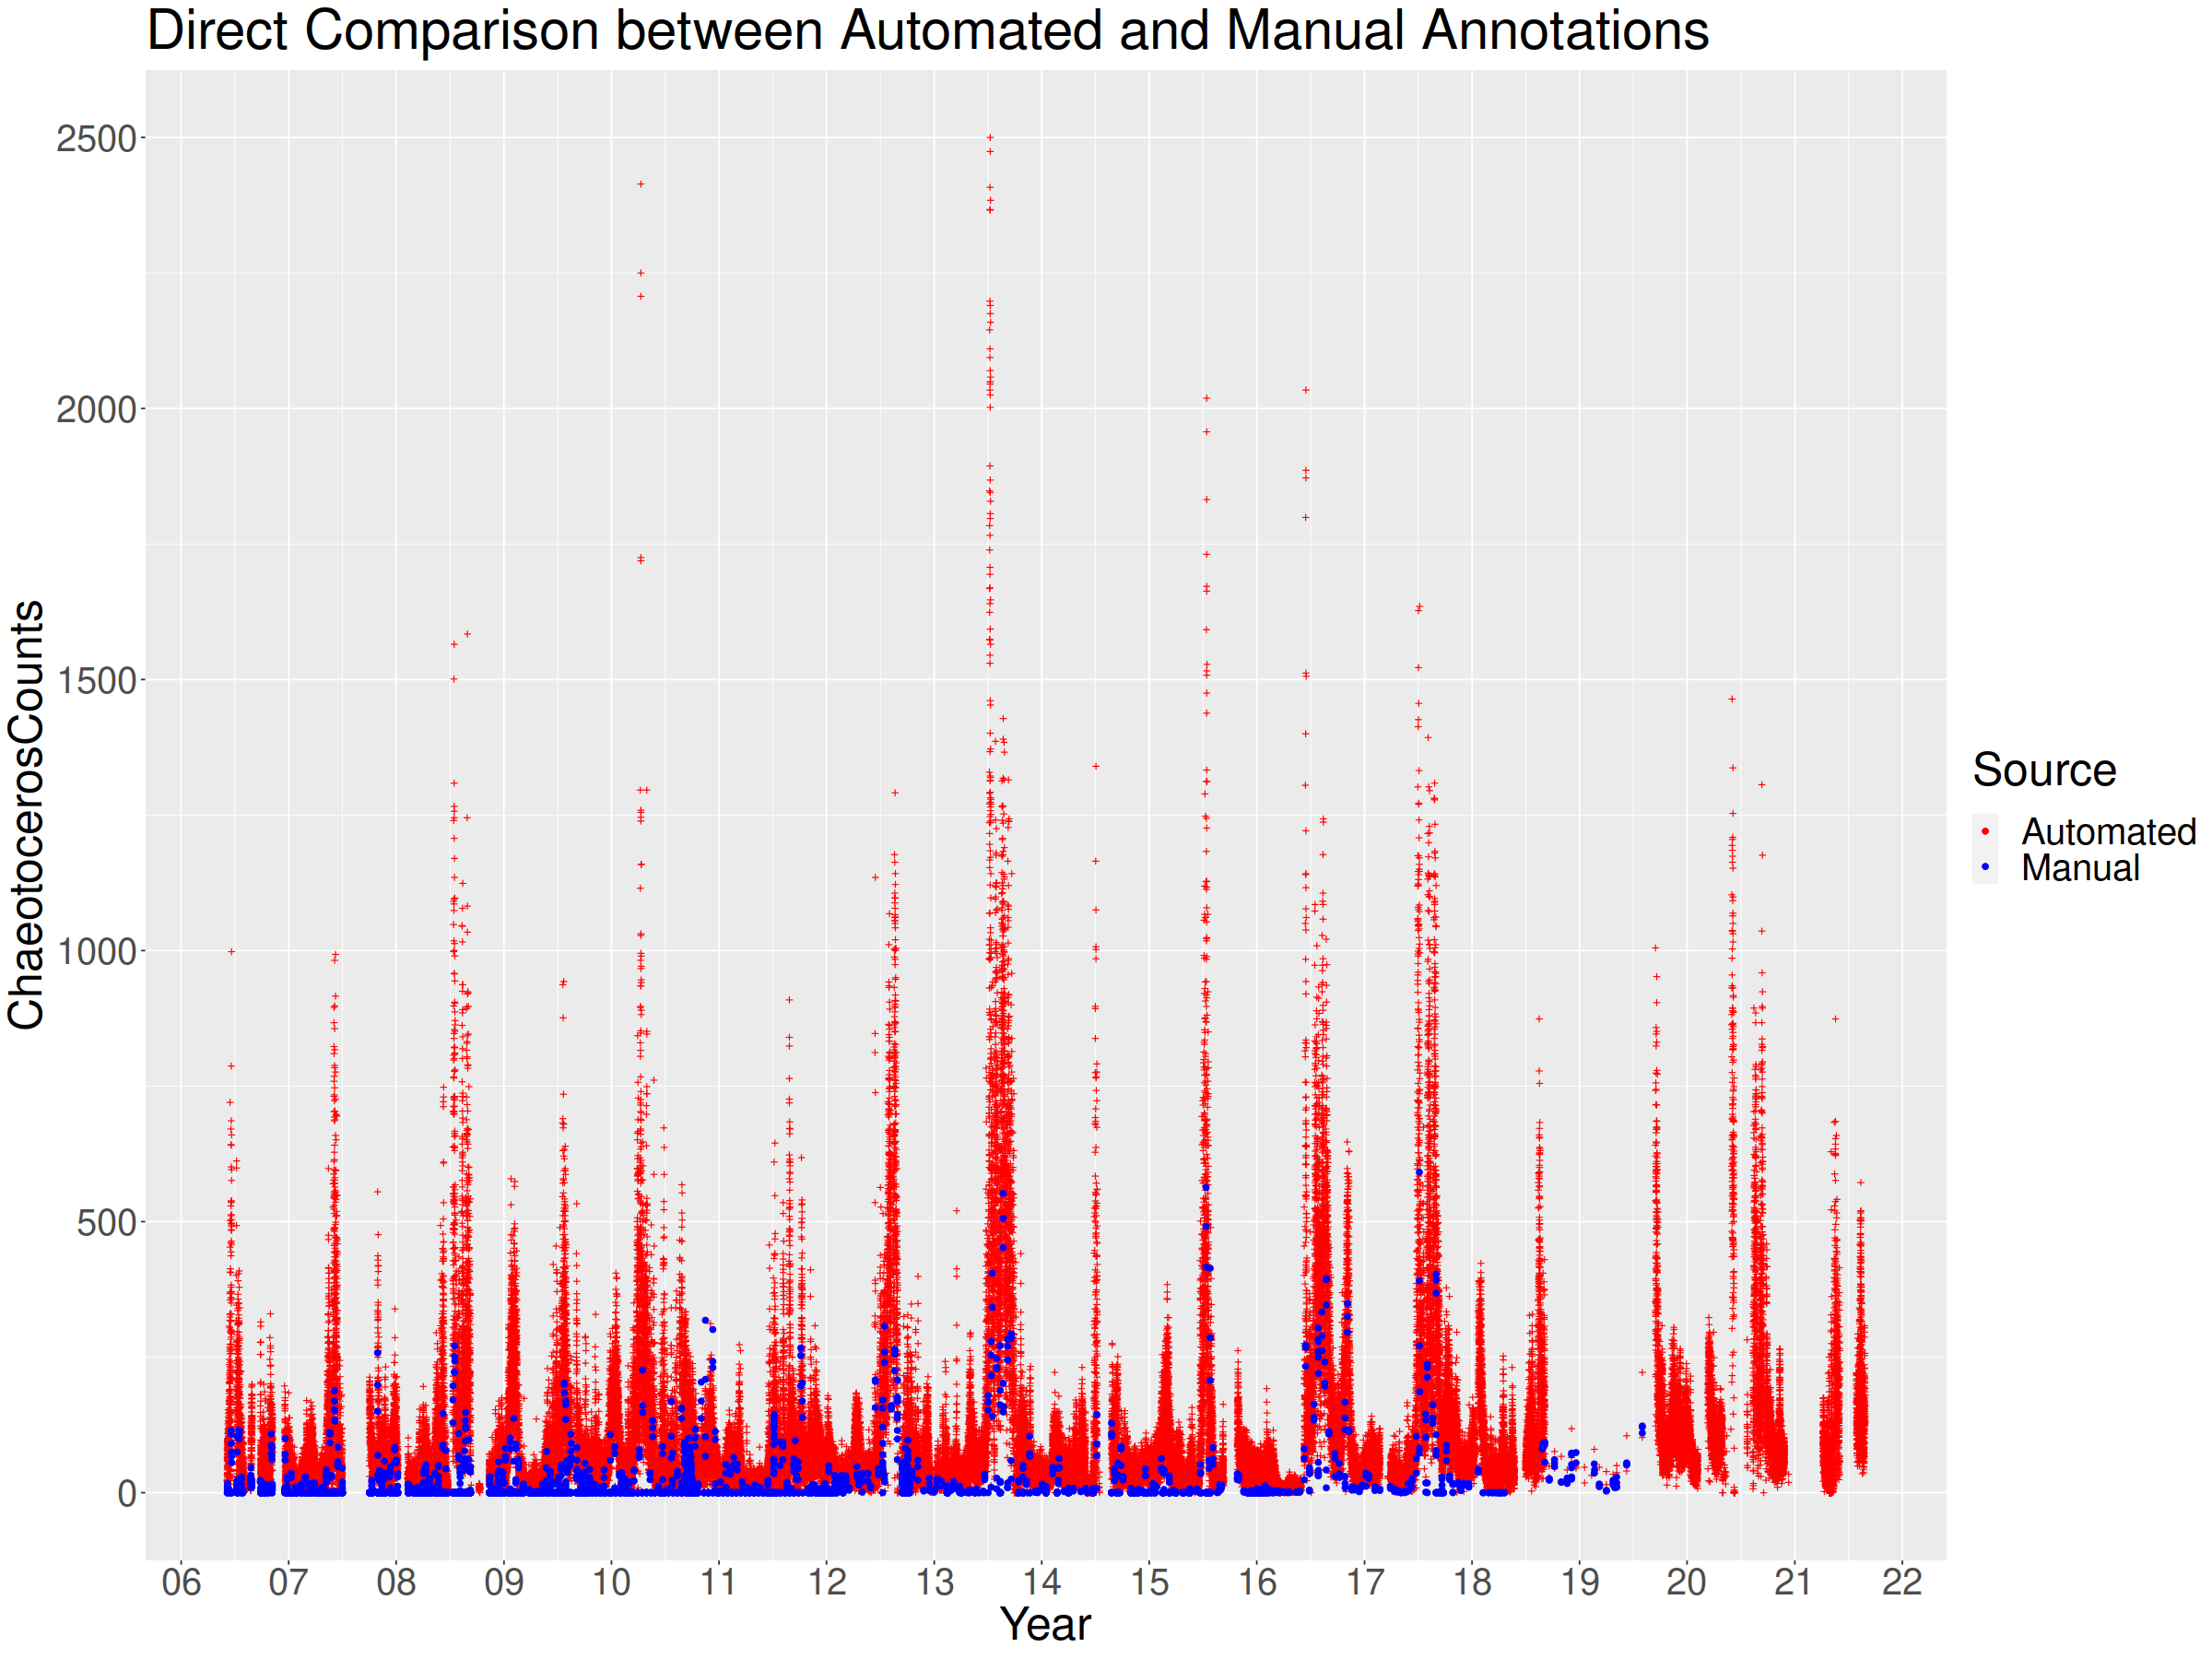

In [51]:
options(repr.plot.width=20, repr.plot.height=15) #set plot size


ggplot() +
    geom_point(data = dfc, aes(x =datetime, y=Chaetoceros, color = "Automated"),shape = 3, size = 1)+
    geom_point(data = dfm, aes(x =datetime, y=Chaetoceros, color = "Manual"))+
    theme(text = element_text(size = 30))+
    scale_x_date(breaks = "1 year", labels=date_format("%y"))+
    xlab("Year")+
    ylab(paste0("Chaeotoceros","Counts"))+
    scale_color_manual(name = "Source", values = c("Automated" = "red", "Manual" = "blue"))+
    ggtitle("Direct Comparison between Automated and Manual Annotations")

### Zooming in on specific years

Warning message:
“Removed 54 rows containing missing values (geom_point).”


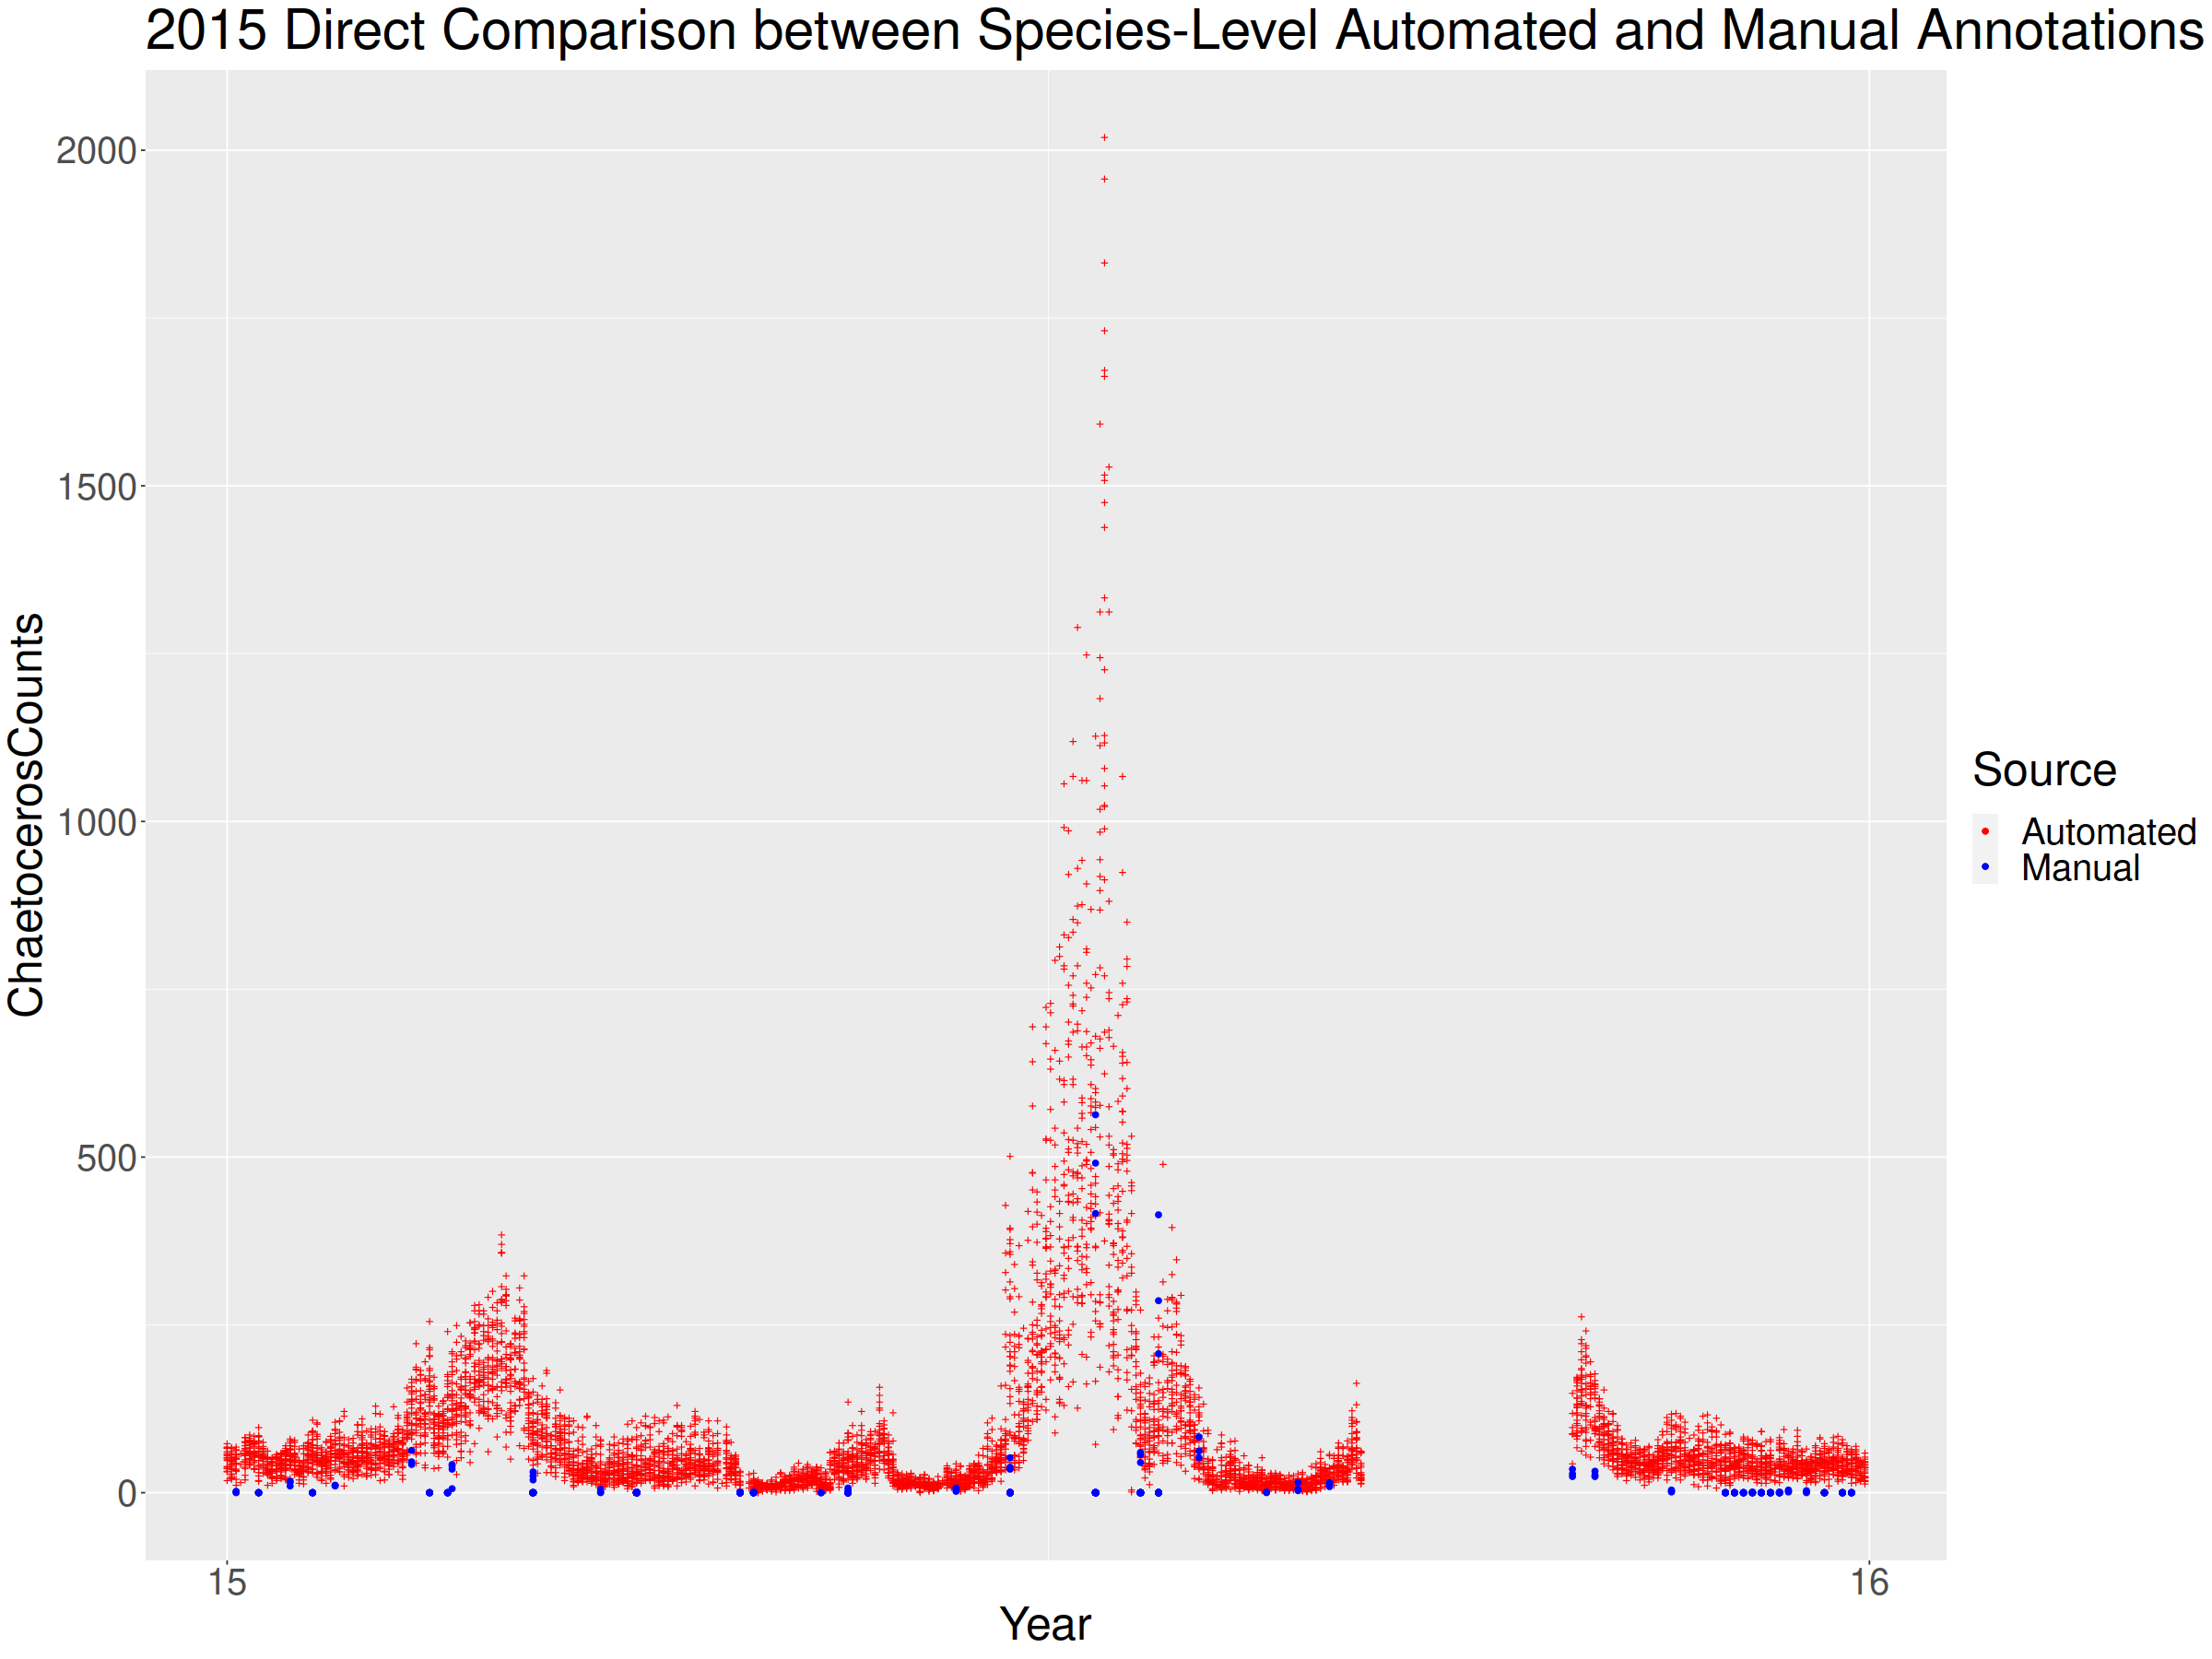

In [42]:
options(repr.plot.width=20, repr.plot.height=15) #set plot size

plt.year = 2015
ggplot() +
    geom_point(data = dfc%>% filter(year == plt.year), aes(x =datetime, y=Chaetoceros, color = "Automated"),shape = 3, size = 1)+
    geom_point(data = dfm %>% filter(year == plt.year), aes(x =datetime, y=Chaetoceros, color = "Manual"))+
    theme(text = element_text(size = 30))+
    scale_x_date(breaks = "1 year", labels=date_format("%y"))+
    xlab("Year")+
    ylab(paste0(species,"Counts"))+
    scale_color_manual(name = "Source", values = c("Automated" = "red", "Manual" = "blue"))+
    ggtitle(paste(plt.year,"Direct Comparison between Species-Level Automated and Manual Annotations"))

In [46]:
intersect(colnames(dfc),colnames(dfm))

[1] "datetime"                     "Acanthoica_quattrospina"     
  [3] "Akashiwo"                     "Alexandrium_catenella"       
  [5] "Amphidinium"                  "Amylax"                      
  [7] "Apedinella"                   "Asterionellopsis_glacialis"  
  [9] "Bacillaria"                   "Bacillariophyceae"           
 [11] "Bacteriastrum"                "Balanion"                    
 [13] "Biddulphia"                   "Calciopappus"                
 [15] "Calciosolenia_brasiliensis"   "Cerataulina_pelagica"        
 [17] "Ceratium"                     "Ceratium_furca"              
 [19] "Ceratium_lineatum"            "Chaetoceros"                 
 [21] "Chaetoceros_danicus"          "Chaetoceros_didymus"         
 [23] "Chaetoceros_peruvianis"       "Chaetoceros_socialis"        
 [25] "Chaetoceros_subtilis"         "Chaetoceros_throndsenii"     
 [27] "Chrysochromulina"             "Chrysochromulina_lanceolata" 
 [29] "Corethron_hystrix"            "Corymbellus"                 
 [31] "Coscinodiscus"                "Cylindrotheca"               
 [33] "Dactyliosolen_blavyanus"      "Dactyliosolen_fragilissimus" 
 [35] "Delphineis"                   "Dictyocha"                   
 [37] "Didinium"                     "Dinobryon"                   
 [39] "Dinophyceae"                  "Dinophysis_acuminata"        
 [41] "Dinophysis_norvegica"         "Ditylum_brightwellii"        
 [43] "Emiliania_huxleyi"            "Ephemera"                    
 [45] "Eucampia"                     "Euglena"                     
 [47] "Euplotes"                     "Eutintinnus"                 
 [49] "Favella"                      "Gonyaulax"                   
 [51] "Guinardia_delicatula"         "Guinardia_flaccida"          
 [53] "Guinardia_striata"            "Gyrodinium"                  
 [55] "Hemiaulus"                    "Heterocapsa_rotundata"       
 [57] "Heterocapsa_triquetra"        "Karenia"                     
 [59] "Katodinium_or_Torodinium"     "Lauderia_annulata"           
 [61] "Leegaardiella_ovalis"         "Leptocylindrus"              
 [63] "Leptocylindrus_mediterraneus" "Licmophora"                  
 [65] "Margalefidinium"              "Mesodinium"                  
 [67] "Odontella"                    "Ophiaster"                   
 [69] "Oxytoxum"                     "Paralia_sulcata"             
 [71] "Parvicorbicula_socialis"      "Phaeocystis"                 
 [73] "Pleuronema"                   "Pleurosigma"                 
 [75] "Polykrikos"                   "Prorocentrum"                
 [77] "Prorocentrum_micans"          "Prorocentrum_triestinum"     
 [79] "Proterythropsis"              "Protoperidinium"             
 [81] "Pseudochattonella_farcimen"   "Pyramimonas"                 
 [83] "Pyramimonas_longicauda"       "Radiozoa"                    
 [85] "Rhizosolenia"                 "Scrippsiella"                
 [87] "Skeletonema"                  "Stenosemella_morphotype1"    
 [89] "Stenosemella_pacifica"        "Stephanopyxis"               
 [91] "Strobilidium"                 "Strombidium_capitatum"       
 [93] "Strombidium_conicum"          "Strombidium_inclinatum"      
 [95] "Strombidium_morphotype1"      "Strombidium_morphotype2"     
 [97] "Strombidium_oculatum"         "Strombidium_wulffi"          
 [99] "Syracosphaera_pulchra"        "Thalassionema"               
[101] "Thalassiosira"                "Tiarina_fusus"               
[103] "Tintinnida"                   "Tintinnidium_mucicola"       
[105] "Tintinnopsis"                 "Tontonia_appendiculariformis"
[107] "Tontonia_gracillima"          "Vicicitus_globosus"          
[109] "Warnowia"                     "amoeba"                      
[111] "ciliate"                      "coccolithophorid"            
[113] "cryptophyta"                  "flagellate"                  
[115] "flagellate_morphotype1"       "flagellate_morphotype3"      
[117] "pennate"                      "pennate_morphotype1"